In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader
from data import load_traindata
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.optim.lr_scheduler import LambdaLR

In [84]:
torch.manual_seed(42)

In [85]:
num_subclasses = 9000
learning_rate = 3e-5
epochs = 100
seq_size = 1250

In [86]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, seq_size, num_filters=64):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=4, stride=2, padding=1)
        self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(num_filters*2)

        self.conv3 = nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(num_filters*4)

        self.conv4 = nn.Conv1d(in_channels=num_filters*4, out_channels=num_filters*8, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm1d(num_filters*8)

        self.conv5 = nn.Conv1d(in_channels=num_filters*8, out_channels=num_filters*8, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm1d(num_filters*8)

        self.conv6 = nn.Conv1d(in_channels=num_filters*8, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.op = nn.Linear(19,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyRelu(x)

        x = self.conv2(x)
        x = self.bn1(x)
        x = self.leakyRelu(x)

        x = self.conv3(x)
        x = self.bn2(x)
        x = self.leakyRelu(x)

        x = self.conv4(x)
        x = self.bn3(x)
        x = self.leakyRelu(x)

        x = self.conv5(x)
        x = self.bn4(x)
        x = self.leakyRelu(x)

        x = self.conv6(x)
        x = self.leakyRelu(x)
        x = self.op(x)
        x = self.sigmoid(x)
        return x.squeeze(2)
# seq_size = 1250
# batch_size = 32
# model = Discriminator(seq_size)

# sample_input = torch.randn(batch_size, 1, seq_size)
# output = model(sample_input)

# print(output.shape)


In [87]:
#todo
#add self connections and dropout

In [88]:
class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_filters = 32):
        super(Generator, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(num_filters, num_filters*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*2),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(num_filters*2, num_filters*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*4),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv1d(num_filters*4, num_filters*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*8),
            nn.LeakyReLU(0.2)
        )
        self.enc5 = nn.Sequential(
            nn.Conv1d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*8),
            nn.LeakyReLU(0.2)
        )
        self.enc6 = nn.Sequential(
            nn.Conv1d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*8),
            nn.LeakyReLU(0.2)
        )
        self.enc7 = nn.Sequential(
            nn.Conv1d(num_filters*8, num_filters*16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*16),
            nn.LeakyReLU(0.2)
        )

        # Decoder 
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*16, num_filters*8, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(num_filters*8),
            nn.Dropout1d(0.2),
            nn.ReLU(),

        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1, output_padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters*8),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters*8),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*8, num_filters*4, kernel_size=4, stride=2, padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters*4),
            nn.ReLU()
        )
        self.dec5 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*4, num_filters*2, kernel_size=4, stride=2, padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters*2),
            nn.ReLU()
        )
        self.dec6 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*2, num_filters, kernel_size=4, stride=2, padding=1, output_padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters),
            nn.ReLU()
        )
        self.dec7 = nn.ConvTranspose1d(num_filters, out_channels, kernel_size=4, stride=2, padding=1)  # Skip connection, no BN
        self.final_activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        # Encoder
        x = x.unsqueeze(1)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)
        #print(e7.shape, "END OF ENCODER")

        # Decoder with skip connections
        d1 = e6 + self.dec1(e7)
        d2 = e5 + self.dec2(d1)  
        d3 = e4 + self.dec3(d2)
        d4 = e3 + self.dec4(d3)
        d5 = e2 + self.dec5(d4)
        d6 = e1 + self.dec6(d5)
        d7 = self.dec7(d6)
        return self.final_activation(d7)

In [89]:
X, _ = load_traindata(num_subclasses)
X = torch.tensor(X, dtype=torch.float32)
X = X.reshape(num_subclasses, int(5000 / seq_size), seq_size, 12)
X = X.reshape(num_subclasses *  int(5000 / seq_size), seq_size, 12)
X_input = X[:, :, 0]  # First channel
Y_target = X[:, :, 1]  # Second channel


(9514, 28)


In [92]:
dataset = TensorDataset(X_input, Y_target)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator(seq_size).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0005)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
print(sum(p.numel() for p in generator.parameters())/1e6, 'M parameters for Generator')
print(sum(p.numel() for p in discriminator.parameters())/1e6, 'M parameters for Discriminator')

2.448897 M parameters for Generator
1.743317 M parameters for Discriminator


In [93]:
def plotWave(X, Y):
    plt.figure(figsize=(20, 6))
    plt.plot(X.squeeze(0).detach().cpu().numpy(), color='blue', label='X')
    plt.plot(Y.squeeze(0).detach().cpu().numpy(), color='red', label='Y')
    plt.legend()
    plt.show()

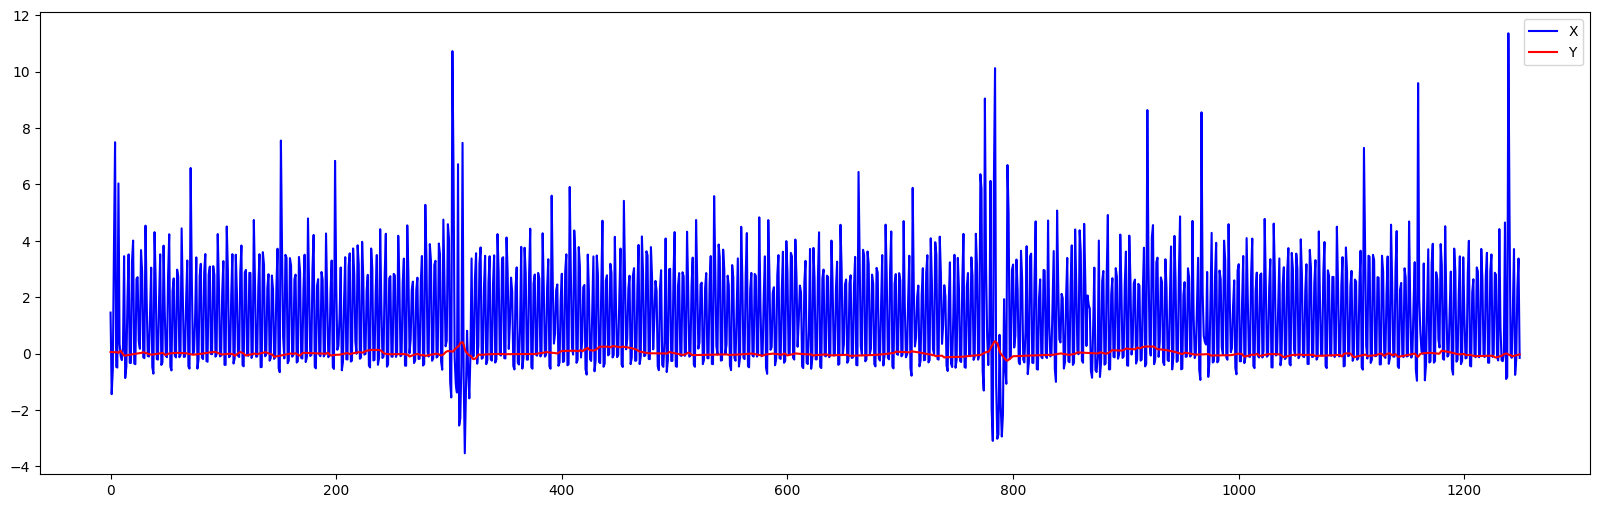

Epoch 1/100, D Loss: 0.010557185858488083, G Loss: 4.412204265594482


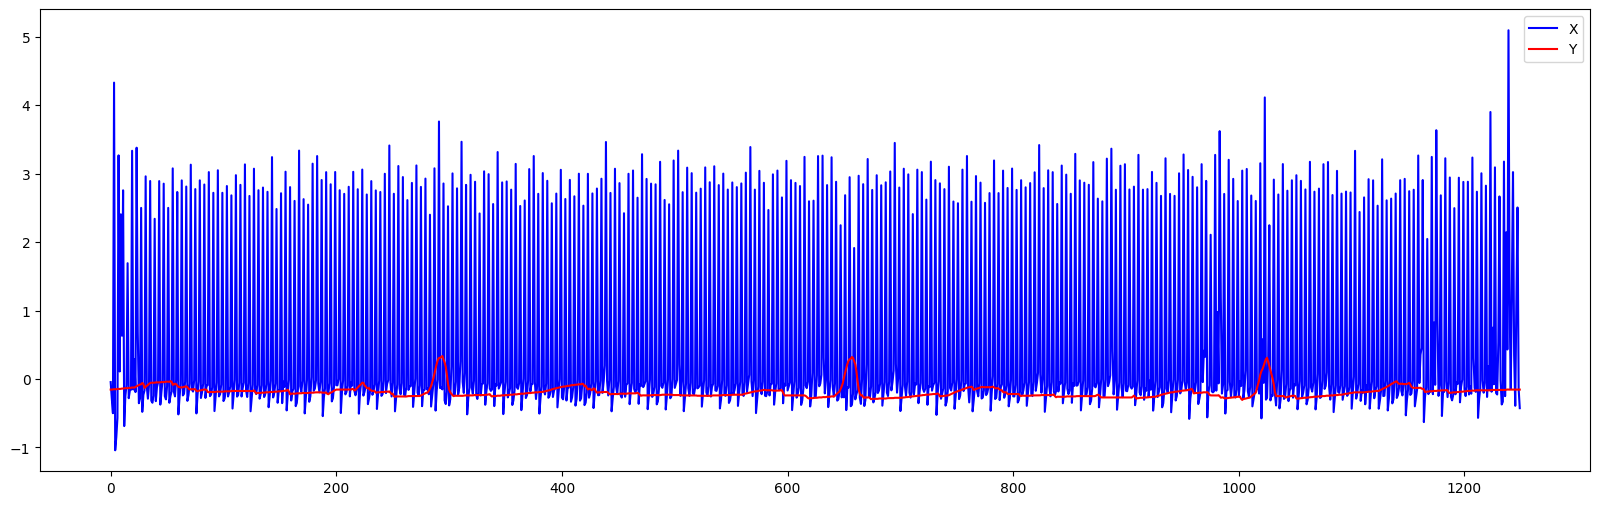

Epoch 2/100, D Loss: 0.001172080053947866, G Loss: 6.381380081176758


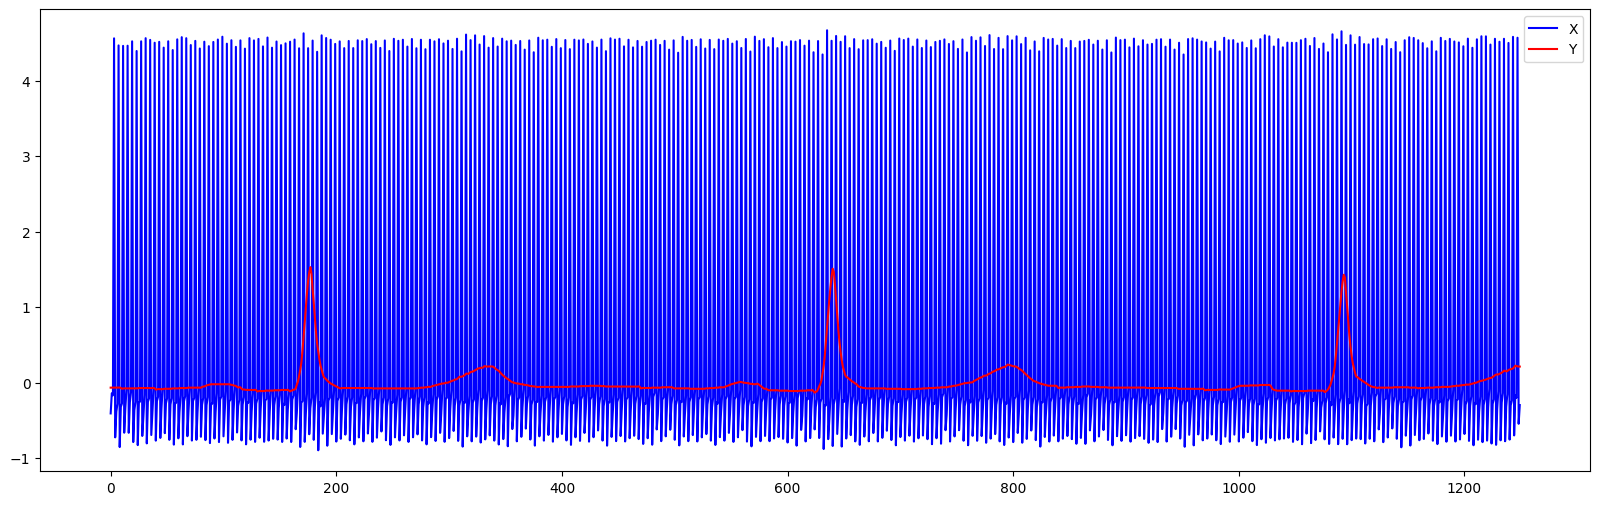

Epoch 3/100, D Loss: 0.0006947387009859085, G Loss: 6.985599040985107


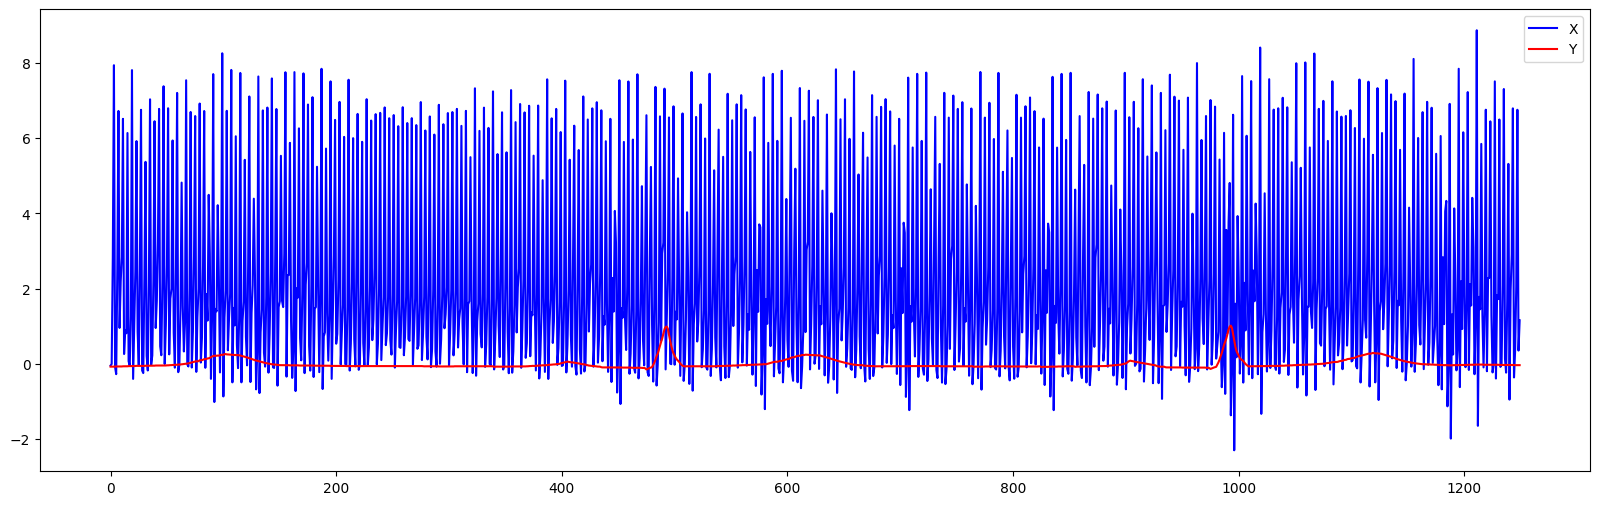

Epoch 4/100, D Loss: 0.00012196417083032429, G Loss: 8.524107933044434


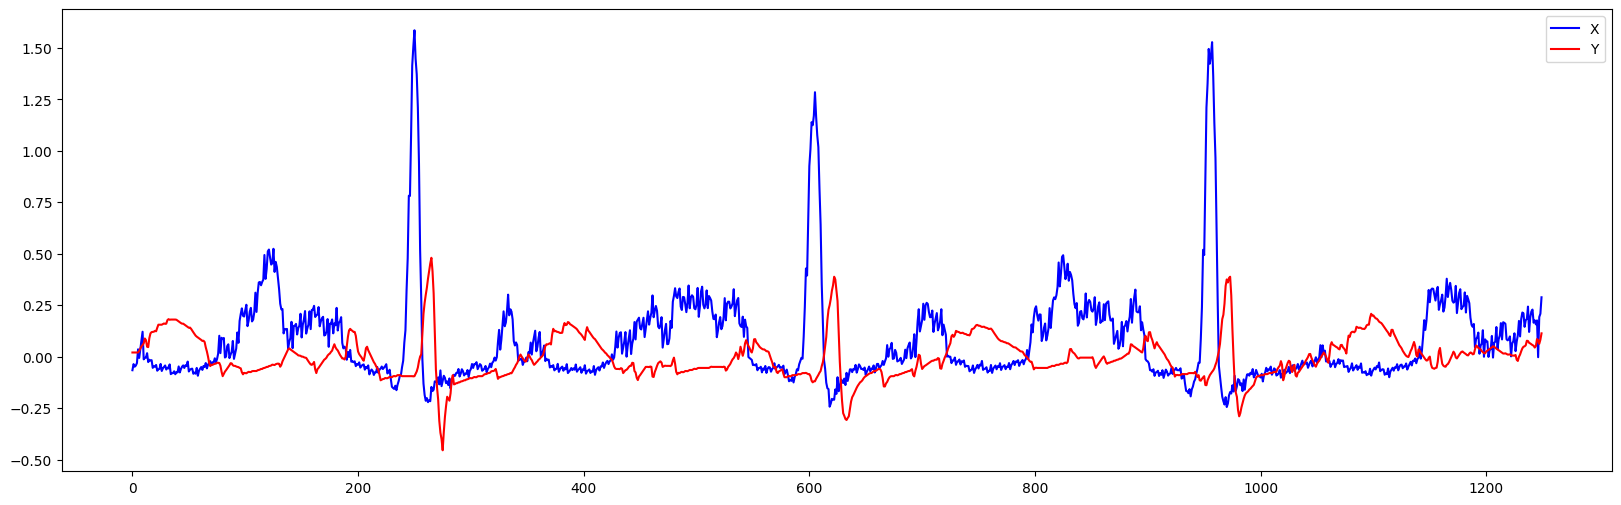

Epoch 5/100, D Loss: 1.0022722482681274, G Loss: 3.572183132171631


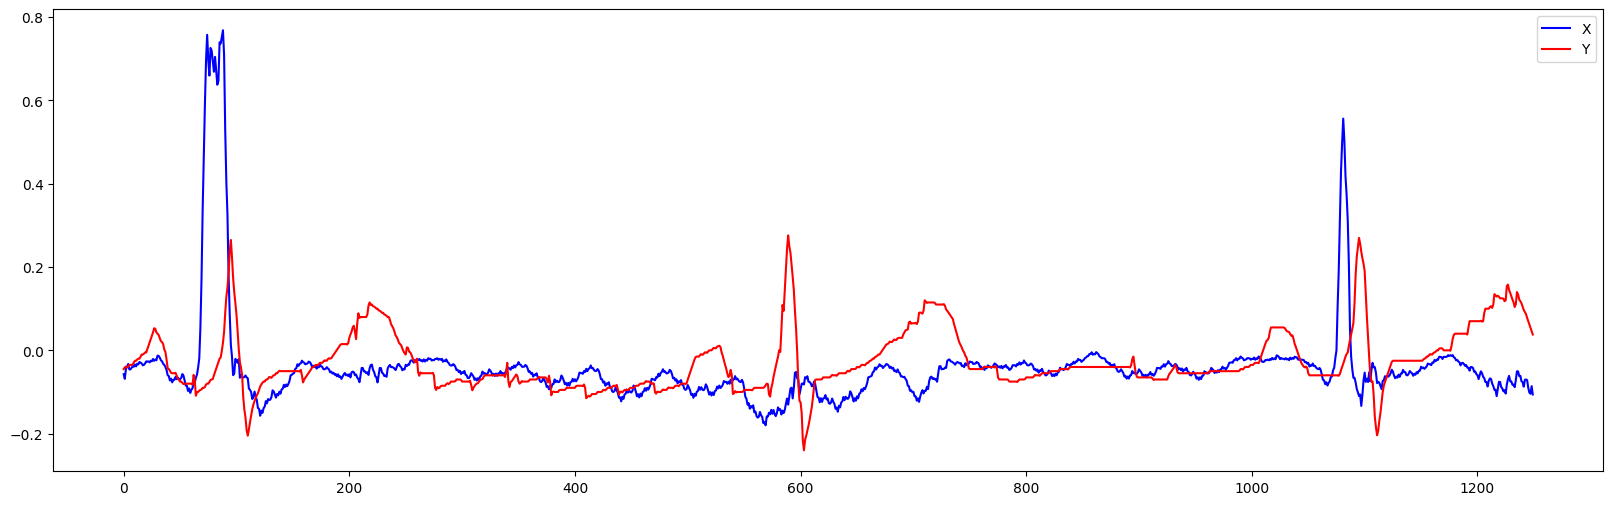

Epoch 6/100, D Loss: 0.009455789811909199, G Loss: 4.1981000900268555


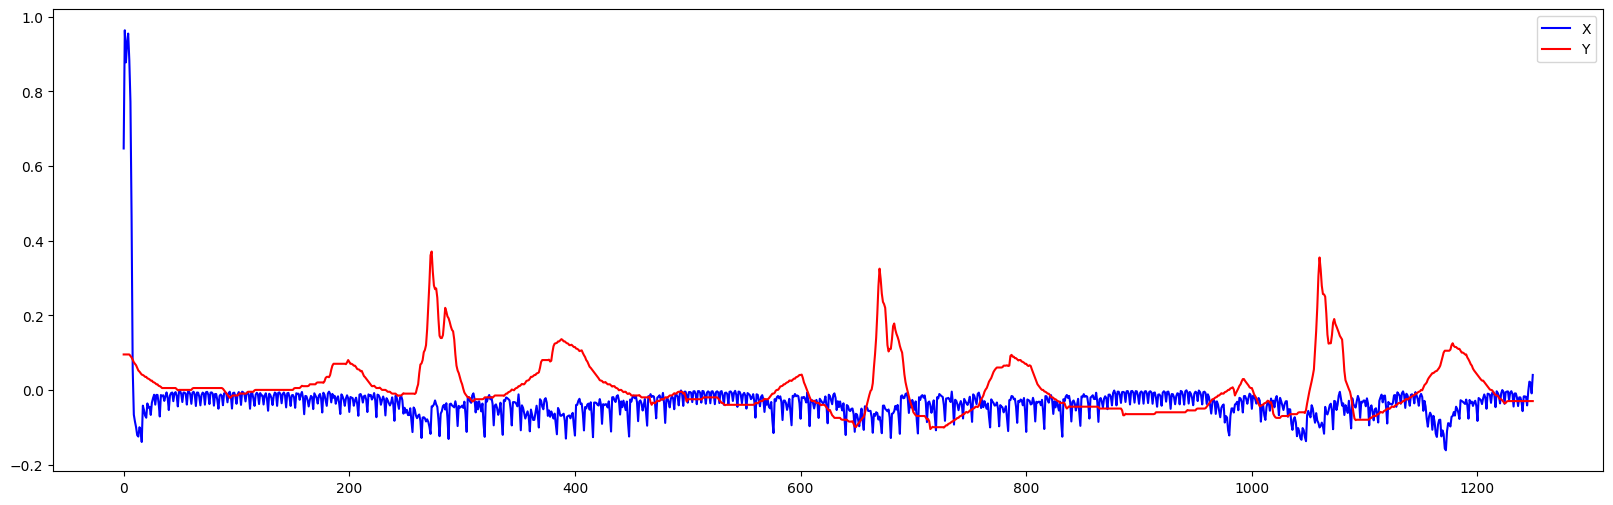

Epoch 7/100, D Loss: 0.006982025690376759, G Loss: 4.6020402908325195


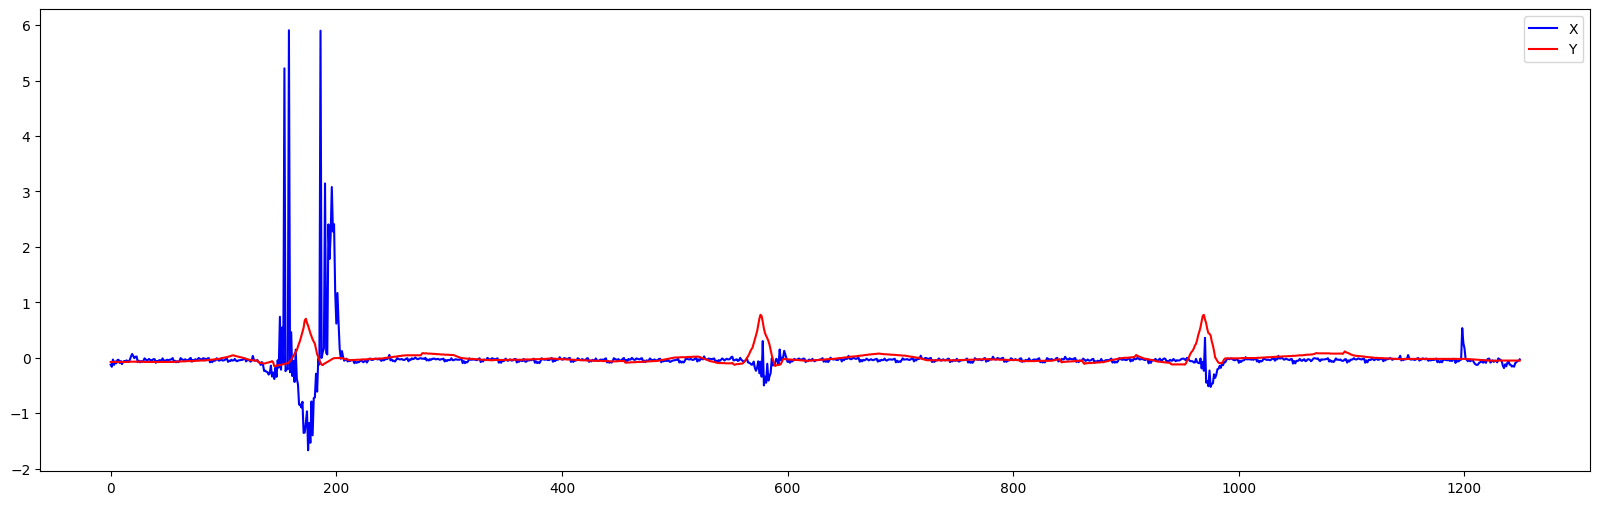

Epoch 8/100, D Loss: 0.0016147420974448323, G Loss: 5.957653999328613


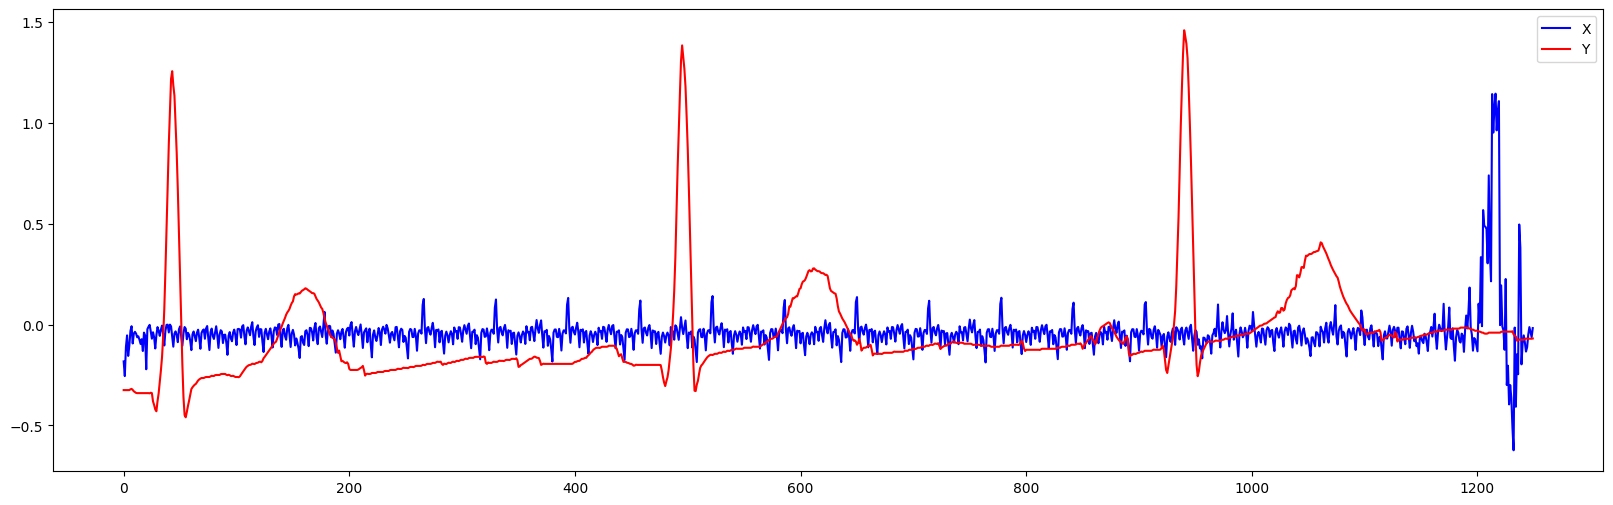

Epoch 9/100, D Loss: 0.00012431590585038066, G Loss: 8.612492561340332


KeyboardInterrupt: 

In [94]:
g_losses, d_losses = [], []
for epoch in range(10):
    for real_1, real_2 in dataloader:
        real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
        real_1, real_2 = real_1.to(device), real_2.to(device)
        batch_size = real_1.size(0)
        
        # Train Discriminator
        optimizer_d.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        fake_2 = generator(real_1)
        fake_output = discriminator(fake_2.detach())
        fake_loss = criterion(fake_output, fake_labels)
        real_2  = real_2.unsqueeze(1)
        real_output = discriminator(real_2)
        real_loss = criterion(real_output, real_labels)
        
        d_loss = (real_loss + fake_loss)
        d_loss.backward()
        optimizer_d.step()
        
        # Train Generator
        optimizer_g.zero_grad()
        fake_output = discriminator(fake_2)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_g.step()
        
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    for real_1, real_2 in dataloader:
        real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
        real_1, real_2 = real_1.to(device), real_2.to(device)
        fake_2 = generator(real_1)
        plotWave(fake_2[0],real_2[0])
        break
    print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
